In [1]:
import lenstronomy
import pkg_resources as pr
pr.get_distribution("lenstronomy").version

'0.4.0'

In [2]:
import matplotlib.pyplot as plt
import pickle
from lenstronomy.Plots.output_plots import LensModelPlot
import numpy as np
import pandas as pd
import scipy.integrate as integrate
from lenstronomy.Sampling.parameters import Param
# from lenstronomy.Workflow.parameters import Param
import time as time
import corner
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math 

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Helvetica'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'custom'

sns.set(style='ticks', context='paper', font='Helvetica', font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in", "axes.linewidth": .8, })

In [3]:
# Load the config file
config_file = pd.read_excel("/Users/edenmolina/PycharmProjects/Quasar/Lenstronomy/LenstronomyConfig.xlsx", sheet_name="Master")
Names = config_file['Name']
Paths = config_file['Path']
RunBool = config_file['RunBool']
SourceVisibleBool = config_file['SourceVisble']

In [4]:
def getData(Path, LensName, sourcevisiblebool):
    """
    Path: path of the pickle file
    LensName: Name of the lenss to be worked with
    SourceVisibleBool: Tells which kwargs_constraint pickle to load
    """
    pick_path = Path
    
    kwargs_model = pickle.load(open("%s/kwargs_model_%s.pickle" % (pick_path, LensName), 'rb'))
    kwargs_params = pickle.load(open("%s/kwargs_params_out_result_%s.pickle" % (pick_path, LensName), 'rb'))

    # Load the kwargs_constraint based on if the source is visible or not in the image
    if sourcevisiblebool == 0:
        kwargs_constraints = pickle.load(open("%s/kwargs_constraintsSI.pickle" % (pick_path), 'rb'))

    else:
        kwargs_constraints = pickle.load(open("%s/kwargs_constraintsSV.pickle" % (pick_path), 'rb'))
        
    lens_result = pickle.load(open("%s/lens_result_%s.pickle" % (pick_path, LensName), 'rb')) 

    # Load the Chain and select every nth values because neighboring valuesi n the chain are correlated with eachother
    chain = pickle.load(open("%s/MCMC_Chain_%s.pickle" % (pick_path, LensName), 'rb'))

    print ("***THIS IS THE SHAPE OF THE CHAIN INSIDE GET PARAM***", np.shape(chain))

    n = 10
    chain = chain[::n]
    
    param = Param(kwargs_model, kwargs_constraints, 
                  kwargs_params['lens_model'][2], 
                  kwargs_params['source_model'][2],
                  kwargs_params['lens_light_model'][2],
                  kwargs_params['point_source_model'][2],
                  kwargs_lens_init=lens_result)

    return chain, param

In [5]:
def getLensLightResult(chain, param, i):
    """
    chain: the sliced chain containing posterior distribution of parameters
    param: lenstornomy object needed for getting the lens_light_result
    
    """
    # Need to iterate every column of the chain to get lens_result, source_result...
    lens_result, source_result, lens_light_result, ps_result, _ = param.getParams(chain[i])
 
    return lens_light_result

In [6]:
def getFlux(Path, LensName, sourcevisiblebool):
    """
    path: path to the pickle file
    LensName: name of the lens, used for locating a pickled file
    
    returns: Calculated Magnitude
    """
    
    Chain, param = getData(Path, LensName, sourcevisiblebool)
    
    # Iterate through each of the walkers steps in the chain
    Amplitudes = np.zeros(np.shape(Chain)[0])
    for i in range(np.shape(Chain)[0]):
        lens_light_result = getLensLightResult(Chain, param, i)
        Amplitudes[i] = lens_light_result[0]['amp']
    
    Calculated_Magnitude = np.empty(len(Chain))

    # Calculating the magnitude without performing the Sersic Integeral; gamma values
    n = Chain[:,6] # 
    bn = 1.9992*n - .3271
    I = Amplitudes
    R = Chain[:,5]
    e1 = Chain[:,8]
    e2 = Chain[:,9]    
    gamma = [ math.gamma(2*i) for i in n]
    zero_point = 24.74
    
    q = np.zeros(len(e1))
    for e in range(len(e1)):
        q[e] = lenstronomy.Util.param_util.ellipticity2phi_q(e1[e], e2[e])[1]

        
    # numpy array containing the posterior distribution of magnitudes
    Calculated_Magnitude = q * (zero_point - 2.5 * np.log10(2 * np.pi * n * I * R*R * np.exp(bn)*bn**(-2*n) * gamma))

    return Calculated_Magnitude

# Calculate Magnitudes and Save posterior Distribution as a .txt file

In [10]:
for i in range(len(Names)):
    if RunBool[i] == 1:
        print "Working on %s"%Names[i]
        t0 = time.time()
    
        # Get list of calculated magnitudes
        Calculated_Magnitude = getFlux("/Users/edenmolina/PycharmProjects/Quasar/Lenstronomy", Names[i], SourceVisibleBool[i])

        print "It took %s to compute and plot magnitudes"%round(time.time() - t0, 2)
        
        # Save calculated magnitudes to a file
        np.savetxt("/Users/edenmolina/PycharmProjects/Quasar/Lenstronomy/Mag_%s.txt"%Names[i], Calculated_Magnitude)
        
    else:
        print "Skipping %s" % Names[i], "\n"

Skipping J0047 

Skipping J0246sel 

Skipping J0806 

Skipping J1001 

Skipping J1650 

Skipping J2209 

Skipping J1206 

Working on JU673
('***THIS IS THE SHAPE OF THE CHAIN INSIDE GET PARAM***', (91000, 13))
It took 28.44 to compute and plot magnitudes
Skipping J0048+2505 

Skipping J0118+4718 

Skipping J0130+4110 

Skipping J0252+3420 

Skipping J1700+0058 

Skipping J2103+1100 

Skipping J2209+0045 

Skipping J2211+1929 

Skipping J2246+3118 

Skipping J2257+2349 

Skipping J2353-0539 

Skipping J2003-2111 

Skipping J0235-2433 

Skipping J0259-2338 

Skipping J0508-2748 

Skipping J2213-2652 

Skipping J2305+3714 

Skipping J0140+4107 

Skipping J0245-0557 

Skipping J0246-1845 

Skipping J0417+3325 

Skipping J0446-3102 

Skipping J0840+3550 

Skipping J0949+4208 

Skipping J1012-0307 

Skipping S1128+2402 



# Plot posterior distribution of magnitudes and print out
    * How many items are in the posterior
    * How many of those items above are Nan, Inf, and how many unique items there are

Working on JU673


/anaconda3/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


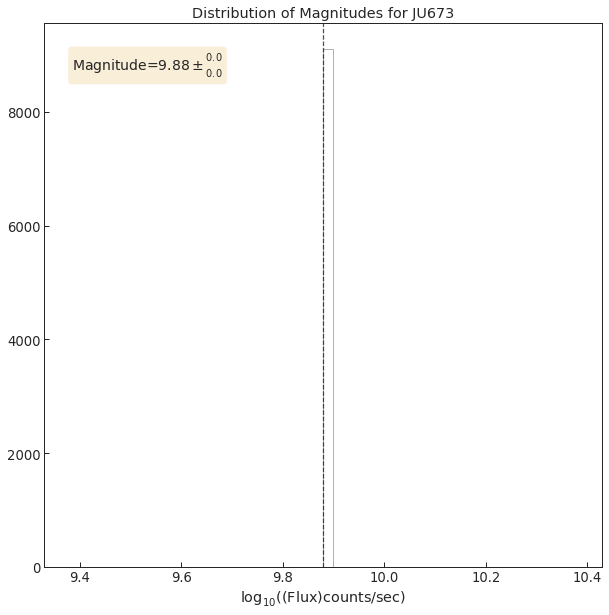

In [8]:
Name, MagnitudeList = list(), list()
for i in range(len(Names)):
    if RunBool[i] == 1:
        print "Working on %s"%Names[i]        
        
        # Load the data
        Calculated_Magnitude = np.loadtxt("/Users/edenmolina/PycharmProjects/Quasar/Lenstronomy/Mag_%s.txt"%Names[i])
        
        # If the calculated magnitdes's arent Nan or Inf if will be plotted
        try:
            plt.close()
            fig, ax = plt.subplots(figsize = (10, 10))
            mag_median = np.median(Calculated_Magnitude)
            mag_lstd = np.quantile(Calculated_Magnitude, .159)
            mag_ustd = np.quantile(Calculated_Magnitude, .841)
            
            err_min = round(mag_median-mag_lstd, 2)
            err_max = round(mag_ustd-mag_median, 2)
#             print "The Magnitude for %s is "%Names[i], mag_median
            ax.hist(Calculated_Magnitude, bins = 50, color = '#A29C9B', histtype='step')
            ax.axvline(x=mag_lstd, color = 'k', linestyle= '--', alpha = .5, markersize = .1)
            ax.axvline(x=mag_ustd, color = 'k', linestyle= '--', alpha = .5, markersize = .1)
            plt.title("Distribution of Magnitudes for %s"%Names[i])
            plt.xlabel(r'$\log_{10}({\rm (Flux)counts/sec})$')
            
            # Making a textbox displaying the statistics for calculated magnitude
            textstr = '\n'.join((
                r'Magnitude=$%.2f \pm ^{%s}_{%s}$' % (mag_median, err_min, err_max),))

            # these are matplotlib.patch.Patch properties
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

            # place a text box in upper left in axes coords
            ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
                    verticalalignment='top', bbox=props)

            plt.savefig("/Users/edenmolina/Desktop/FluxPlots/%s.png" %Names[i])

            Name.append(Names[i])
            MagnitudeList.append(mag_median)
        except:
            print "Either nan or inf magnitude calculated."
            print "Shape of Calculated Magnitude Array: ", np.shape(Calculated_Magnitude)[0]
            print "Non-NaN Values Are: ", Calculated_Magnitude[~np.isnan(Calculated_Magnitude)]
            print "\t", "There are this many Non-NaN : ", np.shape(Calculated_Magnitude[~np.isnan(Calculated_Magnitude)])[0]
            print "Number of inf: ", Calculated_Magnitude[np.isinf(Calculated_Magnitude)]
            print '\t', "There are this many inf : ", np.shape(Calculated_Magnitude[np.isinf(Calculated_Magnitude)])[0]
            print "NaN Values Are: ", Calculated_Magnitude[np.isnan(Calculated_Magnitude)]
            print '\t', "There are this many NaN : ", np.shape(Calculated_Magnitude[np.isnan(Calculated_Magnitude)])[0]
            print ("The Unique Values are: "), np.unique(Calculated_Magnitude)
            print '\t', "The unique values are: ", np.shape(np.unique(Calculated_Magnitude))[0], '\n'

            try:
                print "Calculating values that aren't nan or inf"
                Calculated_Magnitude = Calculated_Magnitude[~np.isnan(Calculated_Magnitude)]
                Calculated_Magnitude = Calculated_Magnitude[~np.isinf(Calculated_Magnitude)]
                print ("NON INF NON NAN ARRAY IS NOW", Calculated_Magnitude)
                plt.close()
                fig, ax = plt.subplots(figsize = (10, 10))
                mag_median = np.median(Calculated_Magnitude)
                mag_lstd = np.quantile(Calculated_Magnitude, .159)
                mag_ustd = np.quantile(Calculated_Magnitude, .841)

                err_min = round(mag_median-mag_lstd, 2)
                err_max = round(mag_ustd-mag_median, 2)
    #             print "The Magnitude for %s is "%Names[i], mag_median
                ax.hist(Calculated_Magnitude, bins = 50, color = '#A29C9B', histtype='step')
                ax.axvline(x=mag_lstd, color = 'k', linestyle= '--', alpha = .5, markersize = .1)
                ax.axvline(x=mag_ustd, color = 'k', linestyle= '--', alpha = .5, markersize = .1)
                plt.title("Distribution of Magnitudes for %s"%Names[i])
                plt.xlabel(r'$\log_{10}({\rm (Flux)counts/sec})$')

                # Making a textbox displaying the statistics for calculated magnitude
                textstr = '\n'.join((
                    r'Magnitude=$%.2f \pm ^{%s}_{%s}$' % (mag_median, err_min, err_max),))

                # these are matplotlib.patch.Patch properties
                props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

                # place a text box in upper left in axes coords
                ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
                        verticalalignment='top', bbox=props)

                plt.savefig("/Users/edenmolina/Desktop/FluxPlots/%s_had_Nan_or_Inf.png" %Names[i])

                Name.append(Names[i])
                MagnitudeList.append(mag_median)
            except:
                print ("All values were either NaN or Inf")
            
    else:
        continue
#         print "Skipping %s" % Names[i], "\n"

# Summarize Results as a Pandas DF

In [12]:
Magnitude_DF = pd.DataFrame({'Name':Name, 'Magnitude':MagnitudeList})

In [14]:
Magnitude_DF[['Name', 'Magnitude']]

,Name,Magnitude
0,JU673,9.879777
